# Natural Language Processing: Disaster Tweets - EDA WIP

# Introduction <br>
The aim of this notebook is to be able to classify tweets into two categories, tweets that are about actual disasters and tweets that are not about disasters. This will be done using NLP and machine learning, on a dataset of 10,000 tweets. 

**DISCLAIMER: SOME TWEETS MAY CONTAIN EXPLICIT LANGUAGE**

**What is NLP?**<br>

NLP stands for Natural Language Processing, this is defined by the Oxford Languages Dictionary as 'The application of computational techniques to the analysis and synthesis of natural language and speech'. Natural language is the way humans talk to each other through things such as text and speech.<br>
Language can be incredibly difficult, it is a thing that takes each one of us years to learn and even then we often make mistakes throughout our lives. NLP as a tool is very powerful but it faces many limitations and problems; such as the ability to understand context, sarcasm, errors in the text, slang, and ambiguity. This can have an impact on how our models may decide the outcome of the tweet so we can already predict that it will make some mistakes when trying to predict the outcome. 

## Let's get started! 

The first steps like in every project are to import our libraries and then read in our data. 

In [1]:
# Install Libs
!pip install pyspellchecker
!pip install keras
!pip install tensorflow-cpu==2.1.0 #No GPU :'(
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 885 kB/s 
     |████████████████████████████████| 1.6 MB 883 kB/s 
     |████████████████████████████████| 104.6 MB 29 kB/s 
     |████████████████████████████████| 26.1 MB 36.8 MB/s 
     |████████████████████████████████| 448 kB 63.9 MB/s 
     |████████████████████████████████| 50 kB 3.7 MB/s 
     |████████████████████████████████| 3.8 MB 48.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=608c64275c4d8943e7962d923ef5786139363656ce7fd80bcbe06bcb9e4627c6
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboa

In [2]:
# Import Libraries 
import io 
import re
import string 
import unicodedata
import spacy 
import matplotlib
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
from spellchecker import SpellChecker
from wordcloud import WordCloud
from IPython.display import display

Now we need to read in our dataset and store it in a dataframe so we can easily access and manipulate it. 

In [3]:
# Read in Data
tweets = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [4]:
# Let's take a look at what the data looks like 
tweets.head(10)
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [5]:
print(f'Rows: {tweets.shape[0]}, Columns: {tweets.shape[1]} in the training data.')
print(f'Rows: {test.shape[0]}, Columns: {test.shape[1]} in the test data.')

Rows: 7613, Columns: 5 in the training data.
Rows: 3263, Columns: 4 in the test data.


So we can see that the test data is missing the target column, but our training data includes this. So the end result is to predict the target column for the test data. 

<AxesSubplot:>

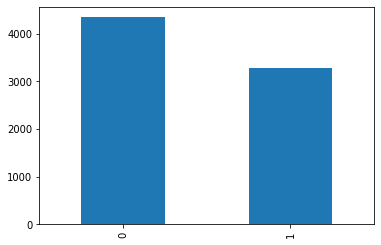

In [6]:
# Lets see what the target looks like 
tweets.describe()
tweets.target.value_counts().plot(kind = 'bar')

There are more tweets with no mention of disaster than tweets with a disaster. This is known as a class imbalance, machine learning models work best when the outcome classes are about equal. It isn't a huge difference so maybe we can play about with reducing this imbalance later if we don't get the results we are hoping for. We will consider a range of measures when trying to determine the performance of the models as accuracy can be flawed when there is a class imbalance. 

In [7]:
tweets['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

# Data Cleaning 

The next step should be to clean the data and make it as usable as possible. I will first make a copy of the data just to be on the safe side.

In [8]:
# Combine both test and train data into a new df for cleaning 
df = pd.concat([tweets, test])
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


Hashtags are a common feature of many tweets and are often used inline, so the symbols should be stripped along with any other special characters. 

In [9]:
test = "[This is just to test] somerandom@text.totest, https://maybe.the/tweet/contains.alink<br>😔, I am a #bad #person corevt the word?"

# Regex
I really don't like how intimidating regex looks and sometimes it can be a little bit of a pain to use, but its perfecct for what we want to do in our data cleaning steps. I took the long steps to writing this by running them in this notebook on a test string to see the outcome, since writing this set of functions I have found this really handy website that helps you figure out what is going on, its also the first result if you google regex debugger. https://regex101.com/ 

# Data Cleaning Functions in more Detail
It should be pretty self explanatory what is happening in the below functions but if this is your first look at NLP let's touch on a couple of things. 

Beautiful Soup - it is a really helpful libarary that let's you grab data from HTML and XML files, you can do things like prettify your documents, grab specific sections, in this case I am using it to grab all of the text regardless of if it is a title or body or any other formatting and leave behind all of the tags so that we just take the usable text. Now I don't use twitter so I don't know how likely this is to occur in our dataset so better to clean it out just in case! https://www.crummy.com/software/BeautifulSoup/bs4/doc/

Spellchecker - I'm not going to manually spellcheck 10,000 tweets, no one has time for that. This is the pyspellchecker library, it will save you so much time! It uses the Levenshtein distance algorithm to determine if a word has a spelling error. Simply put the algorithm looks at how many single characters in a string need to be changed to make it into another word. If it is few and one word exists in the dictionary and the other doesn't, it will change the word to the one in the dictionary, if it is many characters difference then it will leave it alone.  This step isn't necassary, this is one of the really time consuming steps too, while it is running YOU CANNOT SAVE YOUR NOTEBOOK so yeet it into an ipynb or py file too!

No one is making you run the spellchecking, but you really should! It will eliminate duplicate words created by spelling errors, and it will allow you to get improved accuracy in your results too. 

Unless you are doing a degree in english, if you are new to NLP projects, you may of not heard of lemmatization and stop words. <br>

Lemmatization or Lemmatisation if you are from the UK like me, is a process of grouping words together that share the same 'lemma' which is their dictionary form. This is so they can be analysed as a single item. Now if you are checking what your data is looking like at various stages in this process, it may appear to make less sense from a gramatical perspective but the underlying meaning of the text remains.  This isn't an entirely necassary step and there are other approaches you can take to get similar results such as stemming, the difference is that stemming uses the 'stem' of the word which is more objective, it removes the prefixes or suffixes, where as lemmatization looks at the context of the word, so it needs a really detailed dictionary which is what the 'sp = spacy.load('en_core_web_sm');' section of that function is bringing in. 

Lemmatization has been chosen in this case to help increase the recall performance metric. 

The NLTK library is bringing us a lovely list of stop words (But you can also define them yourself if you want to be specific!), we have so many words in this data set and not all of them are needed to determine if the tweet is mentioning disaster, these are words like 'And', 'a', 'the' and such, the words that we use to add more sense and flow to what we say. For example, you could say 'I am pretty sure there was just an earthquake near Kailua-Kona, HI', removing the stopwords would give us 'pretty sure, just earthquake near Kailua-Kona, HI' which doesn't sound great but it still implies that there was an earthquake. https://www.nltk.org/book/ch02.html

This removes the aspect of pointless words that only serve to make the text flow better to us having an impact on determining that a natural disaster was mentioned in the tweet. It is unlikely that more tweets that mention disaster aslo use the word 'The' for example, but if that was the case there is a chance our model later on in the notebook may use that as a determining factor which would give us pretty useless results. 



In [10]:
# Remove any links 
def remove_hyperlink(data):
    isurl = re.compile(r'https?://\S+|www.\.\S+')
    return isurl.sub(r'', data)

# Remove any special characters
def remove_special_chars(data):
    data = re.sub('[,\.!:;()"]', ' ', data)
    data = re.sub('[^a-zA-Z"]', ' ', data)
    data = re.sub('\[[^]]*\]', ' ', data)
    return data

# Make Lower Case
def make_lower(data):
    data = data.str.lower()
    return data

# Remove any HTML
def remove_html(data):
    soup = BeautifulSoup(data, 'html.parser')
    return soup.get_text()

# Remove any Emojis
def remove_emojis(data):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return emojis.sub(r'',data)

# Remove double spaces
def remove_doublespaces(data):
    data = re.sub('  ', ' ', data)
    data = re.sub('  ', ' ', data)
    return data

# Correct Mispellings 
spell = SpellChecker()
def correct_spelling(data):
    corrected = []
    mispellings = spell.unknown(data.split())
    for word in data.split():
        if word in mispellings:
            corrected.append(spell.correction(word))
        else:
            corrected.append(word)
    return " ".join(corrected)


stopw = set(stopwords.words('english'))
# Tokenize and remove stopwords 
def filter_on_stopwords(data):
    word_tokens = word_tokenize(data)
    no_stopword_tokens = [token for token in word_tokens if token not in stopw]
    data = ' '.join(no_stopword_tokens)
    return data

sp = spacy.load('en_core_web_sm')
def lemmatize_words(data):
    doc = sp(data)   
    data = ' '.join([token.lemma_ for token in doc])
    return data

In [11]:
# Call these functions 
test = remove_hyperlink(test)
test = remove_special_chars(test)
#test = make_lower(test) #str has no attrib str, but the actual data is in a series, so the funct works for the actual data
test = remove_html(test)
test = remove_emojis(test)
test = remove_doublespaces(test)
test = correct_spelling(test)
# Outputs the re.subbed and cleansed test string 
test

'This is just to test somerandom text totes I am a bad person correct the word'

# Apply the data cleaning functions to the text

In [12]:
# Now we know that the data cleanining functions work as expected we can apply them to our combibned data
# This can take a really really long time, like up to hours, so be patient! Spellchecking and lemmatizing this many individual words and things that are hardly words is slow :'(
df['text'] = df['text'].apply(remove_hyperlink)
df['text'] = df['text'].apply(remove_special_chars)
df['text'] = make_lower(df['text'])
df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(remove_emojis)
df['text'] = df['text'].apply(remove_doublespaces)
df['text'] = df['text'].apply(correct_spelling)
df['text'] = df['text'].apply(filter_on_stopwords)
df['text'] = df['text'].apply(lemmatize_words)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive -PRON-,1.0
1,4,NaN,NaN,forest fire near la range ask canada,1.0
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1.0
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1.0
4,7,NaN,NaN,get send photo ruby alaska smoke wildfire pour...,1.0


## Data Exploration or to be fancy this is our EDA <br>

Now that the data has been cleaned and the stopwords have been removed, we can do a deeper exploration of the data and see what it looks like and a little bit of an analysis on it, just to see if we have any really obvious patterns that stand out, then we can expect to see our results mirroring this somewhat. 

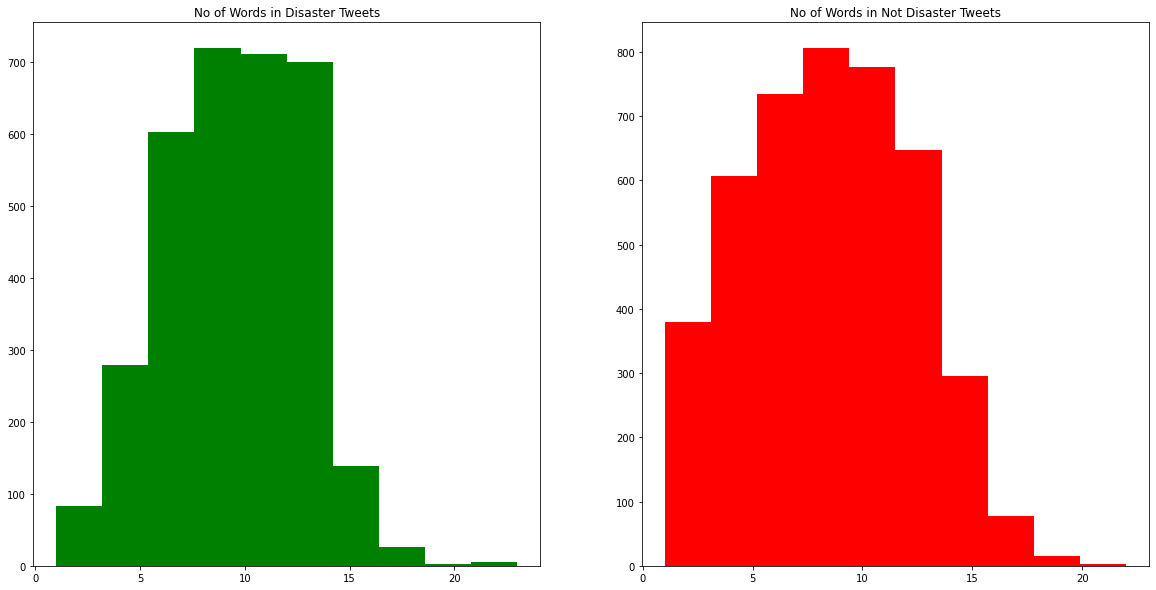

In [13]:
# Number of words in tweets about disaster
len_of_tweet = df[df['target'] == 1]['text'].str.split().map(lambda x: len(x))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.hist(len_of_tweet, color = 'green')
ax1.set_title('No of Words in Disaster Tweets')
len_of_tweet = df[df['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(len_of_tweet, color = 'red')
ax2.set_title('No of Words in Not Disaster Tweets')
plt.show()


Looks like tweets that mention disaster seem to have slightly less words, with number of tweets on the y and number of words on the x

Text(0.5, 1.0, 'Most Common Words in Tweets about Disaster')

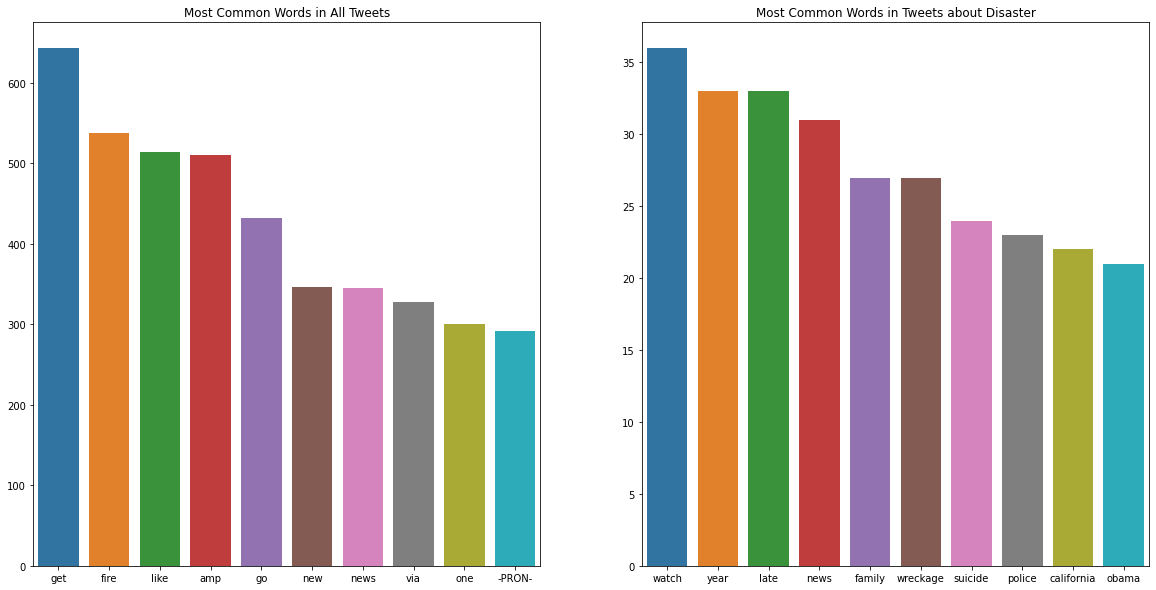

In [14]:
# Get the frequency distribution of the most popular words
words = [word for word in pd.Series(' '.join(df['text']).split())]
most_used_words = FreqDist(words).most_common(10)
most_used_words = pd.Series(dict(most_used_words))
#Plot the most commonly used words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.barplot(x = most_used_words.index, y = most_used_words.values, ax=ax1)

#Get the frequency distribution where tweets are about disaster
disaster_tweets = df[df['target']==1]['text']
disaster_words = [word.split()[0] for word in disaster_tweets]
most_used_disaster_words = FreqDist(disaster_words).most_common(10)
most_used_disaster_words = pd.Series(dict(most_used_disaster_words))
sns.barplot(x = most_used_disaster_words.index, y = most_used_disaster_words.values, ax=ax2)
ax1.set_title('Most Common Words in All Tweets')
ax2.set_title('Most Common Words in Tweets about Disaster')

 Note: -PRON- is replacing any pronoun, I am not sure which library is causing this, likely the spellcheck or lemmatization, people's specific pronouns shouldn't make an impact on this, so I won't worry about this for now.

In [15]:
# Number of unique words
unique_words = []
for word in words:
    if not word in unique_words:
        unique_words.append(word)

print(f'Number of Uniques Words: {len(unique_words)}')

Number of Uniques Words: 15833


## Fun Fact
It took 3143.782 seconds to clean the data set, including spellchecking and lemmatizing 15,833 unique words, thats 53-ish mins!

I have never tried a bag of words before or LSA, so let's try it out. 
Code from: https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

In [16]:
# Bag of Words
def _count_vectorizer(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df['text'].tolist()
list_labels = df['target'].tolist()

x_train, x_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size = 0.3, random_state = 0)

x_train_counts, count_vectorizer = _count_vectorizer(x_train)
x_test_counts = count_vectorizer.transform(x_test)

## Latent Semantic Analysis

This is where relationships in the context of the documents are analysed. It assumes that words that have similar meanings will appear close together in a block of text. 


<function matplotlib.pyplot.show(close=None, block=None)>

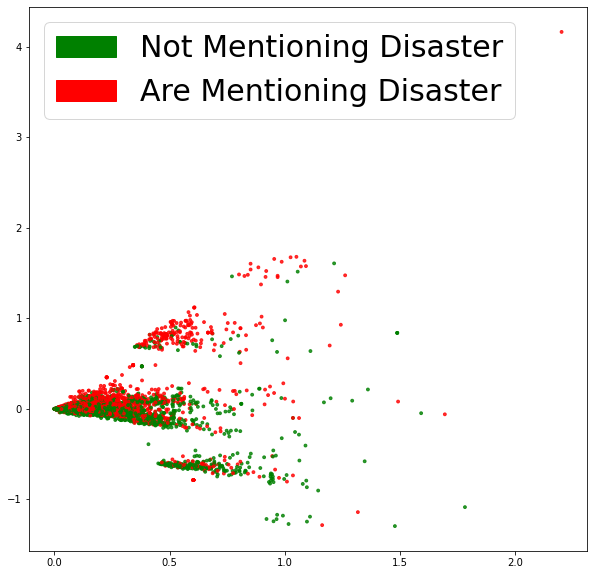

In [17]:
def plot_LSA(data, labels, savepath ='PCA.csv', plot = True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(data)

    lsa_scores = lsa.transform(data)

    color_mapper = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['green','red']

    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s = 8, alpha = .8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        green_patch = matplotlib.patches.Patch(color = 'green', label = 'Not Mentioning Disaster')
        red_patch = matplotlib.patches.Patch(color = 'red', label = 'Are Mentioning Disaster')
        plt.legend(handles = [green_patch, red_patch], prop = {'size':30})

fig = plt.figure(figsize=(10,10))
plot_LSA(x_train_counts, y_train)
plt.show

# Term Frequency - Inverse Document Frequency (TF-IDF)
TF-IDF produces a statistic that reflects how important a word is to a document. It increases proportinally based on the number of times a word appears in the document. This kind of thing is how search engines determine how relavent a search result is to your query. 

<function matplotlib.pyplot.show(close=None, block=None)>

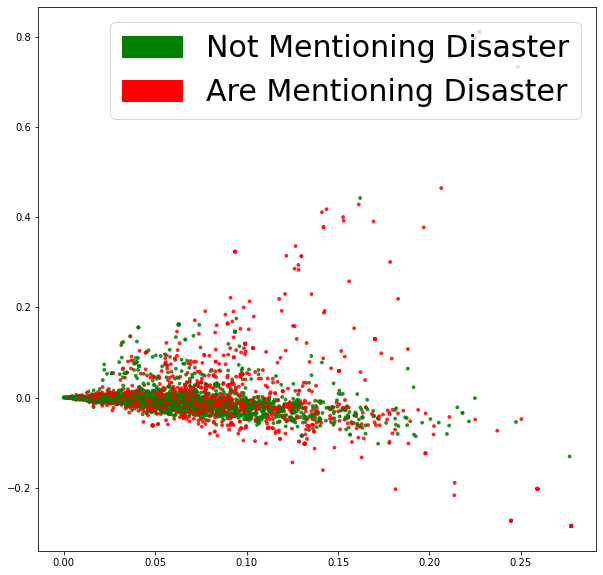

In [18]:
# See how TF IDF looks
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    t = tfidf_vectorizer.fit_transform(data)
    return t, tfidf_vectorizer

x_train_tfidf, tfidf_vectorizer = tfidf(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

fig = plt.figure(figsize=(10, 10))
plot_LSA(x_train_tfidf, y_train)
plt.show

In [19]:
print(x_train[2])

lonewolffur control tora
